# Model Iterations:  model 2

In this notebook, I continue on from the eda, preprocessing done in the 01_eda notebook and aim to improve upon my fsm. 

In [1]:
import os, shutil
import numpy as np
import random
np.random.seed(123)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time
import scipy
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, save_model
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping

parent_dir = '../../'

Using TensorFlow backend.


In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import modelling as m

In [3]:
# plot params:
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['savefig.directory'] = parent_dir + '/figures/'

In [4]:
val_folder = parent_dir + 'data/seg_val/'
test_folder = parent_dir + 'data/seg_test/'
train_folder = parent_dir + 'data/seg_train/'

## Prepare for Modelling

First, we'll reshape the images in all the different datasets and create data generators for them.  I choose batch sizes that are 10% of the size of the datasets

In [5]:
# test generator:
test_gen = ImageDataGenerator(rescale = 1. / 255).flow_from_directory(test_folder, batch_size = 300)

# train generator:
train_gen = ImageDataGenerator(rescale = 1. / 255).flow_from_directory(train_folder, batch_size = 1123)

# val generator:
val_gen = ImageDataGenerator(rescale = 1. / 255).flow_from_directory(val_folder, batch_size = 280)

Found 3000 images belonging to 6 classes.
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [6]:
# create the data sets
train_images, train_labels = next(train_gen)
test_images, test_labels = next(test_gen)
val_images, val_labels = next(val_gen)

Let's explore the shape of these datasets a little more...

In [7]:
def preprocess_image(path_list):
    output = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(256, 256))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = np.divide(x, 255.0)
        output.append(x)
        array = np.vstack(output)
        rows = array.shape[0]
    return array.reshape(rows, 196608)

In [7]:
print ("Number of training samples: " + str(train_images.shape[0]))
print ("Number of pixels in training samples: " + str(train_images.shape[1]))
print ("Number of testing samples: " + str(test_images.shape[0]))
print ("Number of pixels in testing samples: " + str(test_images.shape[1]))
print ("Number of validation samples: " + str(val_images.shape[0]))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 1123
Number of pixels in training samples: 256
Number of testing samples: 300
Number of pixels in testing samples: 256
Number of validation samples: 280
train_images shape: (1123, 256, 256, 3)
train_labels shape: (1123, 6)
test_images shape: (300, 256, 256, 3)
test_labels shape: (300, 6)
val_images shape: (280, 256, 256, 3)
val_labels shape: (280, 6)


Next, we need to reshape these so that they are a 1 x 2 shape:

In [8]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(1123, 196608)
(300, 196608)
(280, 196608)


Now reshape the labels as well:

In [9]:
train_y = np.reshape(train_labels[:,0], (1123, 1))
test_y = np.reshape(test_labels[:,0], (300, 1))
val_y = np.reshape(val_labels[:,0], (280, 1))

In [10]:
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(1123, 1)
(300, 1)
(280, 1)


In [18]:
train_img[0].shape

(196608,)

## Model 2:

Since I've done a bit more preprocessing this time and scaled the data, I'm hoping to see much better results than the last model.  I'm also going to add more layers and hope that this also improves my results.

In [51]:
model2 = Sequential()
# input layer
model2.add(Dense(units = 64, activation = 'relu', input_shape = (196608, )))
# hidden layers
model2.add(Dense(units = 128, activation = 'relu'))
model2.add(Dense(units = 16, activation = 'relu'))
# output layer
model2.add(Dense(units = 6, activation = 'softmax'))

In [52]:
# compile model:
model2.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [53]:
# view the summary:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                12582976  
_________________________________________________________________
dense_14 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_15 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 102       
Total params: 12,593,462
Trainable params: 12,593,462
Non-trainable params: 0
_________________________________________________________________


In [54]:
callback = EarlyStopping(patience = 10)
results = model2.fit(train_img, train_y, epochs = 80, batch_size = 32, 
                      validation_data = (val_img, val_y))
#, callbacks = [callback]

Train on 1123 samples, validate on 280 samples
Epoch 1/80
1123/1123 [==============================] - 10s 9ms/step - loss: 5.0620 - accuracy: 0.7106 - val_loss: 5.7000 - val_accuracy: 0.1750
Epoch 2/80
1123/1123 [==============================] - 9s 8ms/step - loss: 2.4610 - accuracy: 0.7053 - val_loss: 0.9819 - val_accuracy: 0.8357
Epoch 3/80
1123/1123 [==============================] - 9s 8ms/step - loss: 0.9632 - accuracy: 0.7551 - val_loss: 1.3684 - val_accuracy: 0.3464
Epoch 4/80
1123/1123 [==============================] - 10s 9ms/step - loss: 0.6296 - accuracy: 0.7943 - val_loss: 0.5075 - val_accuracy: 0.8107
Epoch 5/80
1123/1123 [==============================] - 9s 8ms/step - loss: 0.4047 - accuracy: 0.8504 - val_loss: 0.7842 - val_accuracy: 0.8321
Epoch 6/80
1123/1123 [==============================] - 10s 9ms/step - loss: 0.3684 - accuracy: 0.8620 - val_loss: 0.5109 - val_accuracy: 0.7857
Epoch 7/80
1123/1123 [==============================] - 10s 9ms/step - loss: 0.3825 - 

FileNotFoundError: [Errno 2] No such file or directory: '../figures/model_loss.png'

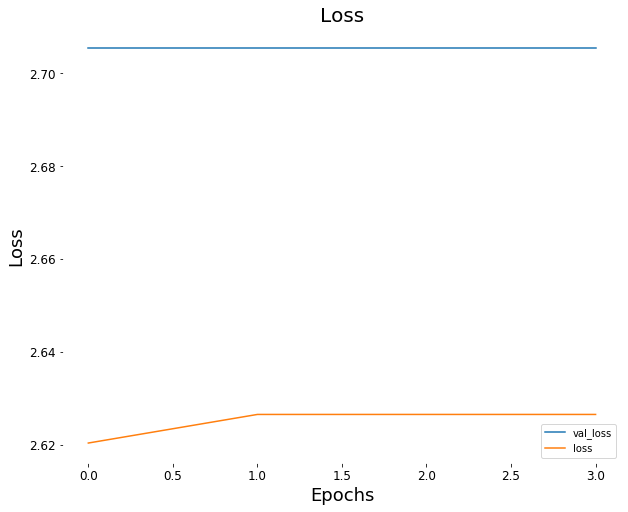

In [20]:
m.visualize_training_results(results)

I manually plotted here so that I could save the image because it wasn't saving from the module function

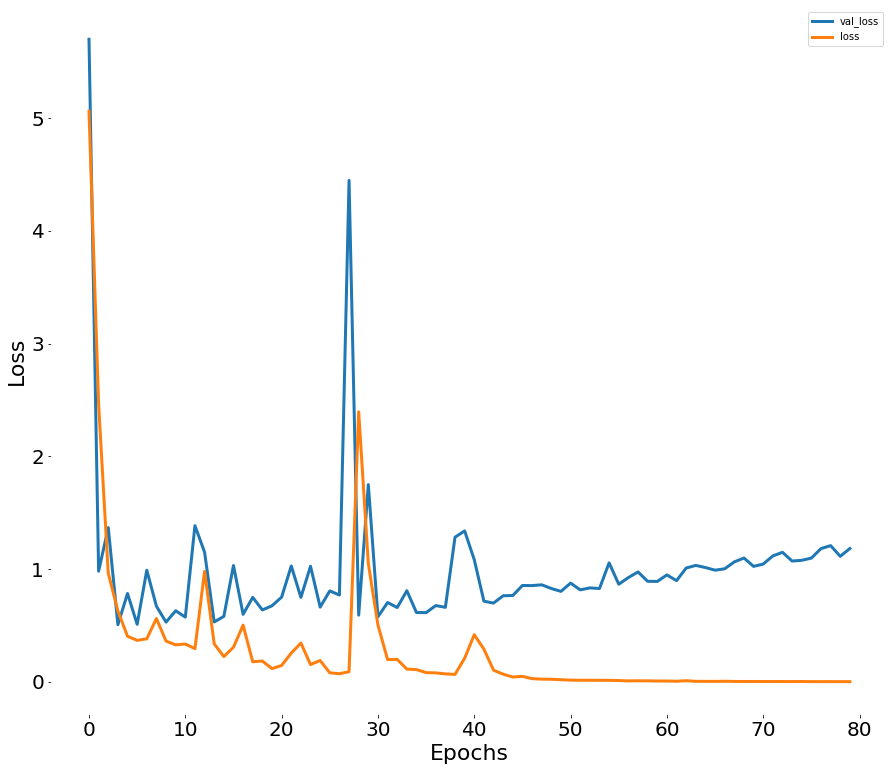

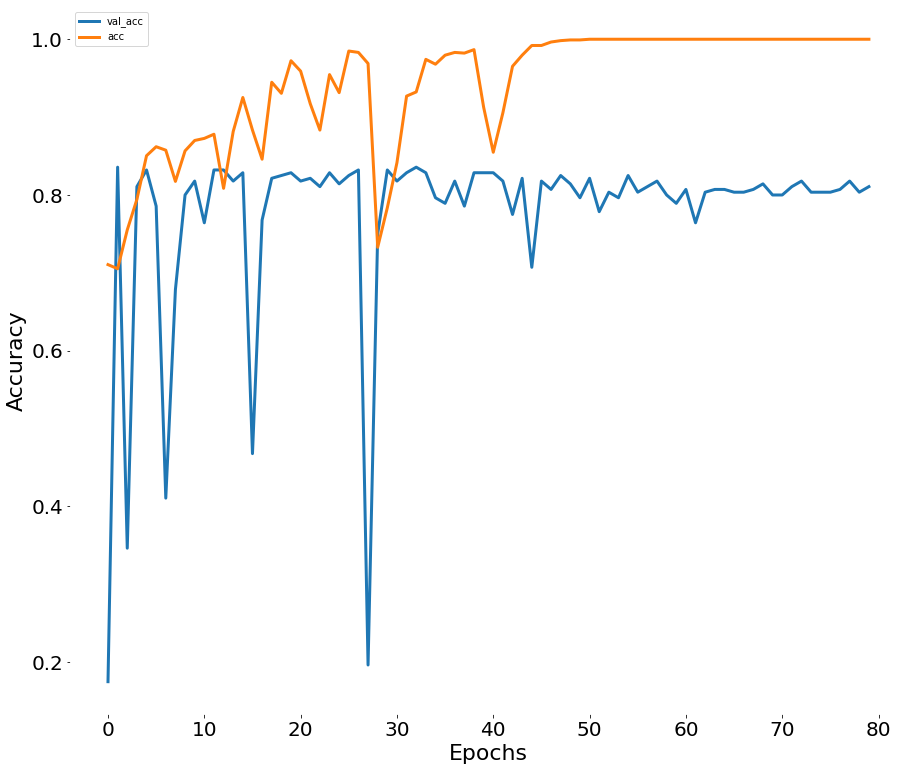

In [55]:
history = results.history
plt.figure(figsize = (15, 13))
plt.plot(history['val_loss'], lw = 3)
plt.plot(history['loss'], lw = 3)
plt.legend(['val_loss', 'loss'])
# plt.title('Model 2 Loss')
plt.xlabel('Epochs', fontsize = 22)
plt.ylabel('Loss', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(parent_dir + 'figures/model2_loss')
plt.show();

plt.figure(figsize = (15, 13))
plt.plot(history['val_accuracy'], lw = 3)
plt.plot(history['accuracy'], lw = 3)
plt.legend(['val_acc', 'acc'])
# plt.title('Model 2 Accuracy')
plt.xlabel('Epochs', fontsize = 22)
plt.ylabel('Accuracy', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(parent_dir + 'figures/model2_accuracy')
plt.show();

So with 80 epochs, we can see the model is overfitting.  The training set has gotten an accuracy of 1 but the validation set is below that and in fact the loss is trending upwards again.

(run the above model again at 25 and 40 epochs to see the lack of convergence again - should actually separate these models out)

In [30]:
history

{'val_loss': [6.054436336244856,
  1.4794765404292516,
  0.8266676247119904,
  2.7544593811035156,
  2.3390076296670097,
  0.959719165308135],
 'val_accuracy': [0.8321428298950195,
  0.8321428298950195,
  0.75,
  0.33571428060531616,
  0.8321428298950195,
  0.8035714030265808],
 'loss': [9.395468967468316,
  1.84833013502193,
  2.354536883234447,
  2.406509089236374,
  0.8866903749514348,
  1.6129070391956442],
 'accuracy': [0.6865539,
  0.78005344,
  0.7551202,
  0.7898486,
  0.79519147,
  0.8005343]}

### Evaluate the model:

In [19]:
results_train = model2.evaluate(train_img, train_y)

1123/1123 [==============================] - 5s 5ms/step


In [20]:
results_test = model2.evaluate(test_img, test_y)

300/300 [==============================] - 1s 4ms/step


Now, comparing our results between train and test:

In [21]:
print(f'Train loss/accuracy:  {results_train}')
print(f'Test loss/accuracy:  {results_test}')

Train loss/accuracy:  [0.4322911105823611, 0.8806767463684082]
Test loss/accuracy:  [0.6501583321889242, 0.8833333253860474]


So, when we inspect the graphs, it looks like the model is overfitting significantly, but when we look at the scale of the y-axis we notice that it's only a difference of 0.004 between the accuracy scores of train and test and a difference of 0.025 between train and validation sets.  So really, there does not appear to be a great deal of overfitting. 

The model also converged after just 2 epochs.  

In [39]:
train_img.shape

(1123, 196608)

Let's have a look at some of the model predictions

In [22]:
preds = model2.predict_classes(train_img)

In [25]:
preds.shape

(1123,)

In [29]:
train_images[344].shape

(256, 256, 3)

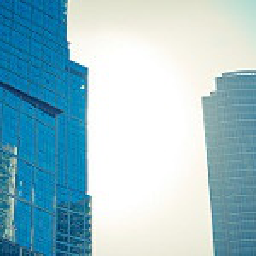

In [27]:
array_to_img(train_images[0])

In [28]:
train_labels[0]

array([1., 0., 0., 0., 0., 0.], dtype=float32)

Hmmm... I'm not sure how to interpret the predictions with the image set itself.... 

## Next

In the next notebook, I'll experiment with creating a CNN and then iterate upon this model and seeing if regularisation might be appropriate.  

### Save Model:

In [16]:
model2.save(parent_dir + 'models/model2_save')

In [33]:
save_model(model2, filepath = parent_dir + 'models/model2', 
           overwrite = True, include_optimizer = True)